In [5]:
pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.8 MB/s eta 0:00:00


In [40]:
import pandas as pd

path = 'https://raw.githubusercontent.com/cleyson02/Time-Series/main/BeerWineLiquor.csv'

dados = pd.read_csv(path)

dados

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822
...,...,...
319,8/1/2018,4898
320,9/1/2018,4598
321,10/1/2018,4737
322,11/1/2018,5130


In [41]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    324 non-null    object
 1   beer    324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


<Axes: >

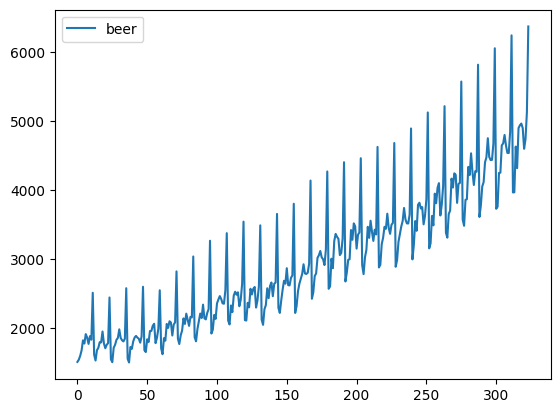

In [8]:
dados.plot()

<Figure size 1200x600 with 0 Axes>

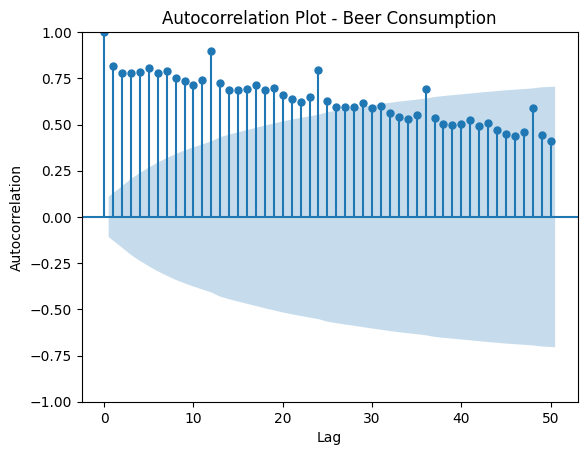

<Figure size 1200x600 with 0 Axes>

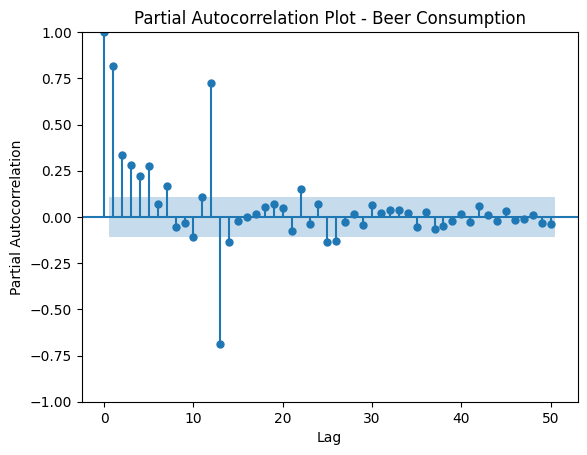

In [42]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotar o gráfico de autocorrelação
plt.figure(figsize=(12, 6))
plot_acf(dados['beer'], lags=50, title='Autocorrelation Plot - Beer Consumption')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plotar o gráfico de autocorrelação parcial
plt.figure(figsize=(12, 6))
plot_pacf(dados['beer'], lags=50, title='Partial Autocorrelation Plot - Beer Consumption')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

# Carregando os dados
path = 'https://raw.githubusercontent.com/cleyson02/Time-Series/main/BeerWineLiquor.csv'
dados = pd.read_csv(path)

# Convertendo a coluna de data para o formato datetime
dados['date'] = pd.to_datetime(dados['date'])

# Renomeando as colunas
dados.rename(columns={'date': 'ds', 'beer': 'y'}, inplace=True)

# Adicionando uma coluna 'unique_id'
dados['unique_id'] = 1

# Definindo a série temporal
series = dados.set_index('ds')

# Dividindo os dados em treinamento e teste
test = dados.groupby('unique_id').tail(24)
train = dados.drop(test.index)

# Definindo os modelos
models = [LGBMRegressor(), LinearRegression()]

# Instanciando o objeto de previsão
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[12],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=12)]
    },
    date_features=['month'],
    target_transforms=[Differences([12])],
)

# Treinando o modelo
fcst.fit(train)

# Fazendo a previsão
predictions = fcst.predict(24)

print(predictions)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 4
[LightGBM] [Info] Start training from score 117.140741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [64]:
series = []
for unique_id in predictions['unique_id'].unique():
  serie = predictions.query("unique_id == @unique_id ")[['LGBMRegressor', 'LinearRegression']]
  series.append(serie)

In [65]:
df_result = series[0]
df_result['target'] = test['y'].values[0:24]

<Axes: >

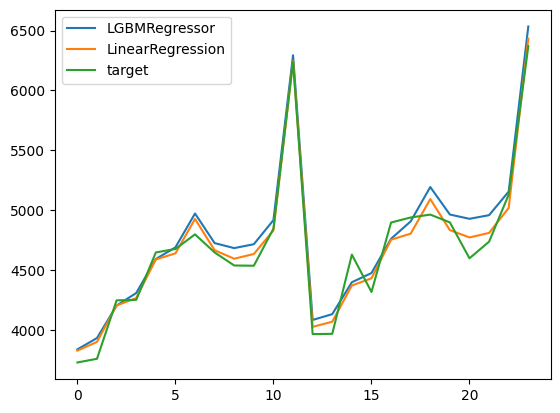

In [66]:
df_result.plot()

In [67]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Erro Percentual Absoluto Médio

MAPE(df_result['target'], df_result['LGBMRegressor'])

0.02761576421119938

In [68]:
MAPE(df_result['target'], df_result['LinearRegression'])

0.01961787679557722